In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# MNISTデータ読み込み
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1,)
X,y = mnist["data"],mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In [29]:
X_train,X_test,y_train,y_test = X[:60000],X[60000:],y[:60000],y[60000:]
shuffle_index = np.random.permutation(60000)
X_train,y_train = X_train[shuffle_index],y_train[shuffle_index]
y_train_5 = (y_train == "5")
y_test_5 = (y_test == "5")

In [30]:
# 手書きデータが5かそれ以外かを判別する二項分類器
# 確率的勾配降下法(SGD)
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(max_iter=5,tol=-np.infty,random_state=42,n_jobs=-1)
sgd_clf.fit(X_train,y_train_5)

# ランダムフォレスト
from sklearn.ensemble import RandomForestClassifier
rfc_clf = RandomForestClassifier(random_state=42,n_jobs=-1)
rfc_clf.fit(X_train,y_train_5)

RandomForestClassifier(n_jobs=-1, random_state=42)

## 分類器の性能評価
分類器の性能評価指標として,正解率, 混同行列, 適合率, 再現率, F値, ROC曲線とAUCがある. このノートでは各評価指標について実行する.

### 正解率
正解率は正しく予測されているインスタンスの割合である.インスタンスの割合. 直感的にはわかりやすい指標であるが一部のクラスが他のクラスよりも出現頻度の高いデータでは役に立たない.

下のセルの実行結果から, SGDよりもランダムフォレストのほうが少し性能が良いと考えられる. しかしすべての予測に"5ではない"と返す分類器の正解率が90%程度であるから, 正解率は分類器の性能指標として用いるべきではないことがわかる.

In [31]:
from sklearn.model_selection import cross_val_score
scores_sgd = cross_val_score(sgd_clf,X_train,y_train_5, cv=3,scoring="accuracy",n_jobs=-1)
scores_rfc = cross_val_score(rfc_clf,X_train,y_train_5, cv=3,scoring="accuracy",n_jobs=-1)
print("正解率(SGD)",scores_sgd)
print("正解率(RFC)",scores_rfc)

正解率(SGD) [0.96475 0.97    0.96575]
正解率(RFC) [0.9873  0.98875 0.9867 ]


In [32]:
# すべての予測に対して"5ではない"を返す分類器
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90605, 0.91205, 0.91085])

### 混同行列
混同行列はあるクラスAのインスタンスがクラスBに分類された回数をカウントしたものを行列で表したものである.

Documents : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html?highlight=confusion_matrix

In [43]:
def disp_confusion_matrix(matrix):
    """
    Description : 混同行列を分かりやすく表示する関数
    Args:
    matrix(np.array(2,2)) : 混同行列
    
    Returns:
    None
    """
    tn, fp, fn, tp = matrix.ravel()
    print("真陽性 : ",tp)
    print("偽陽性 : ",fp)
    print("真陰性 : ",tn)
    print("偽陰性 : ",fn)   

In [45]:
from sklearn.model_selection import cross_val_predict

y_train_pred_sgd = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)
y_train_pred_rfc = cross_val_predict(rfc_clf,X_train,y_train_5,cv=3)

from sklearn.metrics import confusion_matrix
confusion_matrix_sgd = confusion_matrix(y_train_5,y_train_pred_sgd)
confusion_matrix_rfc = confusion_matrix(y_train_5,y_train_pred_rfc)

print("混同行列(SGD)\n",confusion_matrix_sgd)
disp_confusion_matrix(confusion_matrix_sgd)
print("混同行列(RFC)\n",confusion_matrix_rfc)
disp_confusion_matrix(confusion_matrix_rfc)

混同行列(SGD)
 [[53884   695]
 [ 1295  4126]]
真陽性 :  4126
偽陽性 :  695
真陰性 :  53884
偽陰性 :  1295
混同行列(RFC)
 [[54532    47]
 [  698  4723]]
真陽性 :  4723
偽陽性 :  47
真陰性 :  54532
偽陰性 :  698


### 適合率,再現率
適合率は陽性の予測の正解率のことであり,次のように定義される.
$$precision = \frac{TP}{TP+FP}$$

再現率は分類器が正しく分類した陽性インスタンスの割合で,次のように定義される.
$$recall = \frac{TP}{TP+FN}$$

分類器の評価には適合率と再現率の2つを用いて行われる. SGDではprecision=0.77, recall=0.80である. これは分類器が"5"であるといったときの予測が正しいのは77%であり, すべての"5"の80%しか検出できていないことを示している. 一方でランダムフォレストはprecision=0.99, recall=0.87であるからSGDよりもランダムフォレストのほうが性能が良いといえる.

In [37]:
from sklearn.metrics import precision_score,recall_score

print("SGD")
print("適合率 : ",precision_score(y_train_5,y_train_pred_sgd))
print("再現率 : ",recall_score(y_train_5,y_train_pred_sgd))
print("RFC")
print("適合率 : ",precision_score(y_train_5,y_train_pred_rfc))
print("再現率 : ",recall_score(y_train_5,y_train_pred_rfc))

SGD
適合率 :  0.855839037544078
再現率 :  0.7611141855746172
RFC
適合率 :  0.990146750524109
再現率 :  0.8712414683637705


### F値
F値は適合率と再現率の調和平均をとったもので,次のように定義される. 調和平均は小さい値に大きな重みを置くため, 適合率と再現率の両方が高くなればF値が大きな値にならない.
$$F = \frac{2}{\frac{1}{precision}+\frac{1}{recall}}$$

下のセルの実行結果からSGDよりもランダムフォレストのほうがF値が大きいから,ランダムフォレストのほうが性能が良いといえる.

In [38]:
from sklearn.metrics import f1_score

print("SGD")
print("F値 : ",f1_score(y_train_5,y_train_pred_sgd))
print("RFC")
print("F値 : ",f1_score(y_train_5,y_train_pred_rfc))

SGD
F値 :  0.8057020113259129
RFC
F値 :  0.9268962810322833


### ROC曲線とAUC
ROC曲線は縦軸に真陽性率, 横軸に偽陽性率をプロットしたグラフである. ROC曲線からAUCと呼ばれる値を計算することができる. AUCはROC曲線下の面積で定義される. AUC=1のとき完全な分類器であり, AUC=0.5のとき無作為分類器となる.

In [46]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

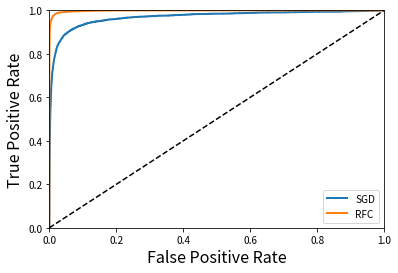

In [54]:
from sklearn.metrics import roc_curve

# SGD
# method : decision_functionを指定することで確率を返す.
scores_sgd = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,method="decision_function")
fpr_sgd,tpr_sgd,thresholds_sgd = roc_curve(y_train_5,scores_sgd)
# RFC
scores_rfc =  cross_val_predict(rfc_clf,X_train,y_train_5,cv=3,method="predict_proba")
fpr_rfc,tpr_rfc,thresholds_rfc = roc_curve(y_train_5,scores_rfc[:,1])

plt.figure(facecolor="white")
plt.plot(fpr_sgd, tpr_sgd, linewidth=2, label="SGD")
plot_roc_curve(fpr_rfc,tpr_rfc,label="RFC")
plt.legend()
plt.show()

In [56]:
# AUC
from sklearn.metrics import roc_auc_score
print("AUC(SGD) : ",roc_auc_score(y_train_5,scores_sgd))
print("AUC(RFC) : ",roc_auc_score(y_train_5,scores_rfc[:,1]))

AUC(SGD) :  0.9688235847356262
AUC(RFC) :  0.9984385585156219
